In [1]:
# ignore warnings
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
# imports
from pathlib import Path
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import pygal
import numpy as np

### cleaning data

In [3]:
# name csv path
ibonds_path = Path("US_Treasury_Series_I_Bond_Historical_Rates.csv")

# read csv
ibonds_df =pd.read_csv(ibonds_path)

ibonds_df.head()

,Date the rate was set,Fixed rate for bonds issued in the six months after that date,Inflation rate for all I bonds issued for six months (starting in that bond's next interest start month)
0,November 1 2022,0.4,3.24
1,May 1 2022,0.0,4.81
2,November 1 2021,0.0,3.56
3,May 1 2021,0.0,1.77
4,November 1 2020,0.0,0.84


In [4]:
# rename columns
ibonds_df.rename(columns={"Date the rate was set":"date", "Fixed rate for bonds issued in the six months after that date":"fixed rate", "Inflation rate for all I bonds issued for six months (starting in that bond's next interest start month)":"six-month inflation rate"}, inplace=True)

# drop nulls
ibonds_df.dropna(axis=0, inplace=True)

# correct error in start dates
ibonds_df["date"][41] = "May 1 2022"
ibonds_df["date"][42] = "November 1 2001"

# add missing data
# source: https://www.treasurydirect.gov/savings-bonds/i-bonds/i-bonds-interest-rates/
new_rows = {"date":["November 1 2023", "May 1 2023"],
    "fixed rate":["1.3", ".90"],
    "six-month inflation rate":["1.97", "1.69"]
}

# create new df
new_rows_df = pd.DataFrame(new_rows)

# concat dataframes
ibonds_combined_df = pd.concat([new_rows_df, ibonds_df])
ibonds_combined_df

# set date to datetime
ibonds_combined_df["date"] = pd.to_datetime(ibonds_combined_df["date"], format="%B %d %Y")

# reset index
ibonds_combined_df.reset_index(inplace=True)

# order ascending
ibonds_combined_df.sort_index(inplace=True, ascending=False)

# set date back as string
ibonds_combined_df["date"] = pd.to_datetime(ibonds_combined_df["date"]).dt.strftime("%m-%Y")

# set index
ibonds_combined_df.set_index("date", inplace=True)

# drop "index"
ibonds_combined_df.drop(columns=["index"], inplace=True)

# set dtypes to correct the manually entered data
ibonds_combined_df["fixed rate"] = ibonds_combined_df["fixed rate"].astype(float)
ibonds_combined_df["six-month inflation rate"] = ibonds_combined_df["six-month inflation rate"].astype(float)

# export cleaned df to csv for other uses
ibonds_combined_df.to_csv("ibonds_cleaned_data.csv")

ibonds_combined_df.head()

,fixed rate,six-month inflation rate
date,,
09-1998,3.4,0.62
11-1998,3.3,0.86
05-1999,3.3,0.86
11-1999,3.4,1.76
05-2000,3.6,1.91


### graphs

calculations

In [5]:
# annualize variable interest rate
ibonds_combined_df["annualized six-month variable interest rate"] = np.maximum((ibonds_combined_df["six-month inflation rate"] * 2), 0)

# combined rate
ibonds_combined_df["aggregate annualized interest rate"] = ibonds_combined_df["annualized six-month variable interest rate"] + ibonds_combined_df["fixed rate"]

ibonds_combined_df.head()

,fixed rate,six-month inflation rate,annualized six-month variable interest rate,aggregate annualized interest rate
date,,,,
09-1998,3.4,0.62,1.24,4.64
11-1998,3.3,0.86,1.72,5.02
05-1999,3.3,0.86,1.72,5.02
11-1999,3.4,1.76,3.52,6.92
05-2000,3.6,1.91,3.82,7.42


stacked bar chart

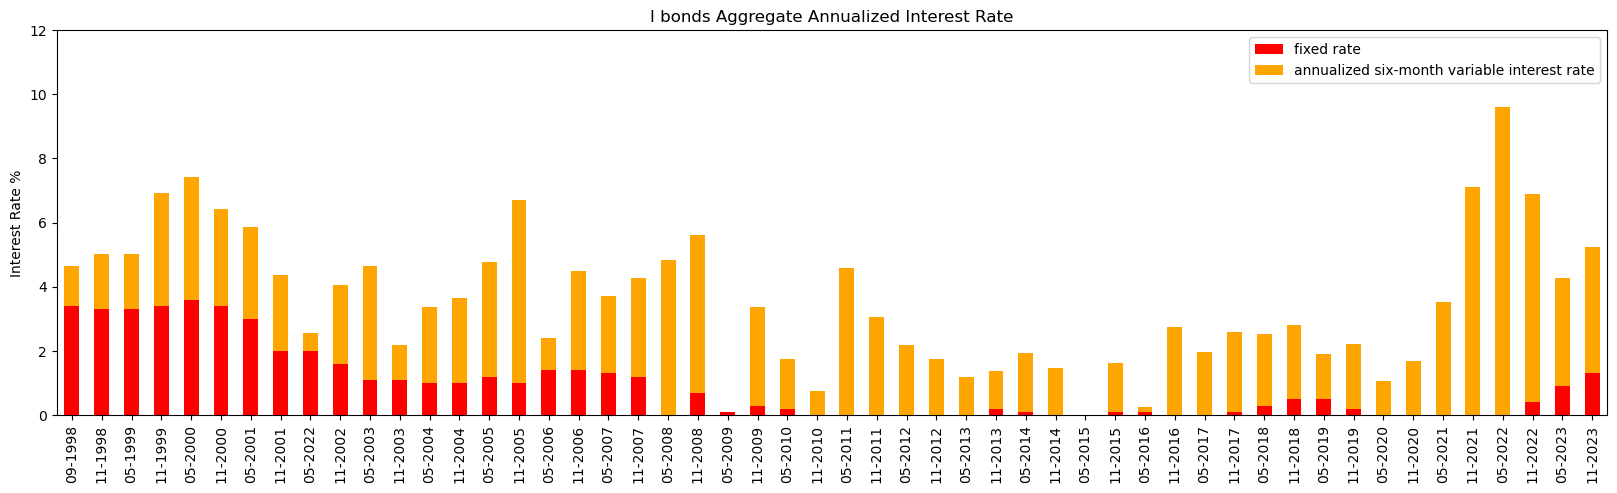

In [11]:
ibonds_bar = ibonds_combined_df.plot(
    y=["fixed rate", "annualized six-month variable interest rate"],
    # set ylim to zero because interest cannot be negative on ibonds
    ylim=(0,12),
    kind="bar",
    stacked=True,
    color=["red", "orange"],
    figsize=(20, 5),
    title="I bonds Aggregate Annualized Interest Rate",
    ylabel="Interest Rate %",
    xlabel=""
    )

